In [59]:
#! /usr/bin/env python
# -*- coding:utf-8 -*-

import os
import argparse
import numpy as np
import cupy as cp
import cv2

import chainer
import chainer.functions as F
import chainer.links as L
from chainercv.datasets import DirectoryParsingLabelDataset

from chainer import Variable
from models.resnet50_fine import ResNet50_Fine

import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
dataset = DirectoryParsingLabelDataset("../datasets/good_condition/")

In [128]:
label = 2
image = dataset.img_paths[3500]
print(image)
result = "result"
weight = "result/2019-09-18-18-34-56/model/2019-09-18-18-34-56_4-1_fold.npz"
classes = 8

../datasets/good_condition/KGMMV/600501.jpg


In [129]:
# 注目したラベルの指定
category_label = label
print('we want {}'.format(category_label))
# pathと画像名に分割する。
#  "../../../tomato_topstem/HEALTHY/***.JPG"
# → parent = "../../../tomato_topstem/HEALTHY/" img_name = "***.JPG"
parent, img_name = os.path.split(image)
# inputした画像の保存先
input_name = '{}/{}'.format(result, 'input_' + img_name)
# heatmap画像の保存先
heatmap_name = '{}/{}'.format(result, 'heatmap_' + img_name)
# grad_cam＠画像の保存先
gradcam_name = '{}/{}'.format(result, 'gradcam_' + img_name)

we want 2


In [130]:
# 画像の読み込み
row_img = cv2.imread(image)
# リサイズ
img = cv2.resize(row_img.astype(np.float32), (224, 224)).transpose((2, 0, 1)) / 255.0
resize_img = img

# 次元を追加したい配列があったときに、次元を追加したい場所にnp.newaxisをおく
# ぶっちゃけよく分からない？
img = img[np.newaxis]

print('Load weight ...')
# モデルのセット
model = L.Classifier(ResNet50_Fine(output=8))
# 重みのロード
chainer.serializers.load_npz(weight, model)

print('finish loading !')
# 画像の
# shape(1, 3, 224, 224)
input_img = Variable(img)

Load weight ...
finish loading !


In [131]:
print(type(img))

<class 'numpy.ndarray'>


In [132]:
# 推測
with chainer.using_config('train', False):
    _, pred, _ = model.predictor(input_img)

In [133]:
# 各クラスの確率の計算
# こんな感じ[1.82548277e-02   7.42741069e-09   9.81745183e-01]
probs = F.softmax(pred).data[0]
print(np.argsort(probs)[::-1])
top = np.argsort(probs)[::-1][0]
print('top1 prob : {}'.format(top))

[7 3 2 6 5 0 1 4]
top1 prob : 7


In [134]:
model.predictor.att

variable([[[[0.4518887 , 0.4518887 , 0.43934125, 0.45258617, 0.38722616,
             0.39717138, 0.4627706 , 0.47575206, 0.42721963, 0.5158177 ,
             0.44816494, 0.45204052, 0.4518887 , 0.4518887 , 0.4518887 ],
            [0.44819006, 0.45483816, 0.4771064 , 0.3930761 , 0.48276484,
             0.37197256, 0.31538606, 0.42212355, 0.35379642, 0.5389911 ,
             0.5014978 , 0.4596333 , 0.47141358, 0.47708502, 0.45148897],
            [0.49238375, 0.4554621 , 0.36590374, 0.46550822, 0.38702178,
             0.55611575, 0.6904432 , 0.6610308 , 0.41957572, 0.46012416,
             0.37469685, 0.34217352, 0.35618517, 0.3725325 , 0.40446916],
            [0.40556386, 0.44729164, 0.42154416, 0.30805823, 0.5466576 ,
             0.7057184 , 0.8828995 , 0.85791844, 0.8685272 , 0.57783324,
             0.3307242 , 0.3443876 , 0.30678892, 0.36325657, 0.37351435],
            [0.41449153, 0.29930836, 0.52240026, 0.72598994, 0.67119473,
             0.89921784, 0.93240476, 0.96484613

In [135]:
print(model.predictor.att.data)
print(model.predictor.att.data.shape)

[[[[0.4518887  0.4518887  0.43934125 0.45258617 0.38722616 0.39717138
    0.4627706  0.47575206 0.42721963 0.5158177  0.44816494 0.45204052
    0.4518887  0.4518887  0.4518887 ]
   [0.44819006 0.45483816 0.4771064  0.3930761  0.48276484 0.37197256
    0.31538606 0.42212355 0.35379642 0.5389911  0.5014978  0.4596333
    0.47141358 0.47708502 0.45148897]
   [0.49238375 0.4554621  0.36590374 0.46550822 0.38702178 0.55611575
    0.6904432  0.6610308  0.41957572 0.46012416 0.37469685 0.34217352
    0.35618517 0.3725325  0.40446916]
   [0.40556386 0.44729164 0.42154416 0.30805823 0.5466576  0.7057184
    0.8828995  0.85791844 0.8685272  0.57783324 0.3307242  0.3443876
    0.30678892 0.36325657 0.37351435]
   [0.41449153 0.29930836 0.52240026 0.72598994 0.67119473 0.89921784
    0.93240476 0.96484613 0.9293246  0.899831   0.5555215  0.36702573
    0.2999132  0.36202225 0.36128473]
   [0.36659777 0.4153902  0.5772275  0.6373763  0.90559494 0.93439066
    0.9741681  0.9477431  0.96113044 0.9322

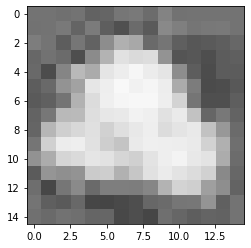

In [136]:
plt.imshow(cv2.cvtColor(model.predictor.att.data[0][0], cv2.COLOR_BGR2RGB))

In [137]:
heatmap = cv2.resize(model.predictor.att.data[0][0], (224, 224))
heatmap = cv2.applyColorMap(np.uint8(heatmap*255), cv2.COLORMAP_JET)
image = img[0, :].transpose(1, 2, 0) * 255
image -= np.min(image)
image = np.minimum(image, 255)
cam_img = np.float32(heatmap) + np.float32(image)
cam_img = 255 * cam_img / np.max(cam_img)

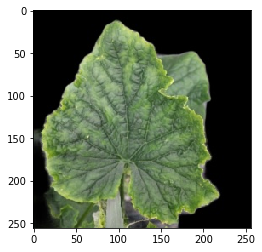

In [138]:
plt.imshow(cv2.cvtColor(row_img, cv2.COLOR_BGR2RGB))

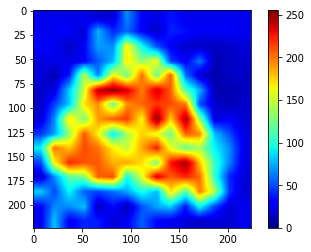

In [173]:
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) ,cmap="jet")
plt.colorbar()

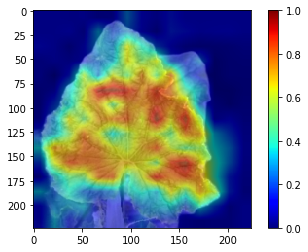

In [172]:
plt.imshow(cv2.cvtColor(cam_img / 255, cv2.COLOR_BGR2RGB) ,cmap="jet")
plt.colorbar()

In [141]:
from PIL import Image
import numpy as np

im = np.array(Image.open('center_attention_map.jpg'))

In [142]:
img_gbr = cv2.imread('center_attention_map.jpg')
img_gray = cv2.cvtColor(img_gbr, cv2.COLOR_BGR2GRAY)

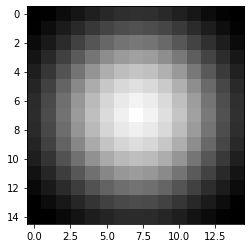

In [143]:
plt.imshow(cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB))

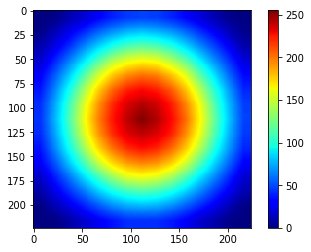

In [171]:
aaa = cv2.resize(img_gray, (224, 224))
aaa = cv2.applyColorMap(np.uint8(aaa), cv2.COLORMAP_JET)
plt.imshow(cv2.cvtColor(aaa, cv2.COLOR_BGR2RGB) ,cmap="jet")
plt.colorbar()

In [145]:
img_gray

array([[  0,   1,  12,  21,  31,  40,  46,  48,  47,  41,  32,  23,  12,
          3,   0],
       [  1,  13,  27,  41,  56,  68,  77,  81,  77,  70,  58,  43,  29,
         14,   3],
       [ 11,  25,  43,  65,  85, 103, 115, 120, 116, 105,  87,  67,  48,
         29,  11],
       [ 20,  40,  64,  90, 117, 141, 154, 160, 156, 142, 121,  94,  68,
         44,  23],
       [ 30,  54,  83, 116, 148, 174, 189, 196, 192, 176, 153, 120,  89,
         58,  33],
       [ 37,  65, 100, 137, 172, 199, 216, 223, 217, 202, 176, 142, 106,
         71,  41],
       [ 43,  73, 111, 150, 186, 214, 233, 243, 236, 218, 191, 157, 116,
         78,  47],
       [ 44,  76, 114, 155, 191, 219, 240, 255, 243, 223, 197, 161, 121,
         81,  48],
       [ 42,  72, 109, 149, 185, 213, 232, 240, 233, 217, 189, 155, 116,
         77,  46],
       [ 36,  65,  99, 135, 170, 196, 213, 221, 215, 199, 174, 141, 104,
         70,  41],
       [ 30,  52,  82, 113, 145, 170, 185, 191, 187, 173, 149, 117,  86,
       

In [146]:
a = np.reshape(img_gray, (1, 1, 15, 15))

In [147]:
x = Variable((a/255).astype(np.float32))

In [148]:
x

variable([[[[0.        , 0.00392157, 0.04705882, 0.08235294, 0.12156863,
             0.15686275, 0.18039216, 0.1882353 , 0.18431373, 0.16078432,
             0.1254902 , 0.09019608, 0.04705882, 0.01176471, 0.        ],
            [0.00392157, 0.05098039, 0.10588235, 0.16078432, 0.21960784,
             0.26666668, 0.3019608 , 0.31764707, 0.3019608 , 0.27450982,
             0.22745098, 0.16862746, 0.11372549, 0.05490196, 0.01176471],
            [0.04313726, 0.09803922, 0.16862746, 0.25490198, 0.33333334,
             0.40392157, 0.4509804 , 0.47058824, 0.45490196, 0.4117647 ,
             0.34117648, 0.2627451 , 0.1882353 , 0.11372549, 0.04313726],
            [0.07843138, 0.15686275, 0.2509804 , 0.3529412 , 0.45882353,
             0.5529412 , 0.6039216 , 0.627451  , 0.6117647 , 0.5568628 ,
             0.4745098 , 0.36862746, 0.26666668, 0.17254902, 0.09019608],
            [0.11764706, 0.21176471, 0.3254902 , 0.45490196, 0.5803922 ,
             0.68235296, 0.7411765 , 0.76862746

In [149]:
b = (model.predictor.att + x) * model.predictor.att
b = b/np.max(b.data)
b

variable([[[[0.109703  , 0.11065502, 0.11480244, 0.1300652 , 0.10584317,
             0.11821428, 0.15989769, 0.16970553, 0.14035466, 0.18749298,
             0.13811609, 0.13168058, 0.12112726, 0.11255906, 0.109703  ],
            [0.10885876, 0.12359677, 0.14942764, 0.11695868, 0.1821624 ,
             0.12762095, 0.10459893, 0.16776145, 0.12463844, 0.23555651,
             0.19639099, 0.15513396, 0.14818925, 0.13634911, 0.11236253],
            [0.14165625, 0.13543358, 0.10507403, 0.1801618 , 0.14977439,
             0.2868196 , 0.42337996, 0.4018625 , 0.19711268, 0.21552204,
             0.14410259, 0.11119848, 0.10417555, 0.09731647, 0.09726065],
            [0.10545224, 0.1451758 , 0.15230238, 0.10939296, 0.29528734,
             0.47719428, 0.7052215 , 0.68459857, 0.6906949 , 0.35223907,
             0.14306836, 0.13191728, 0.09451374, 0.10456256, 0.09304856],
            [0.11849388, 0.08217833, 0.23795709, 0.4605706 , 0.45129973,
             0.76402766, 0.8383141 , 0.8985263 

In [177]:
heatmap = cv2.resize(b.data[0][0], (224, 224))
heatmap = cv2.applyColorMap(np.uint8(heatmap*255), cv2.COLORMAP_JET)
image = img[0, :].transpose(1, 2, 0) * 255
image -= np.min(image)
image = np.minimum(image, 255)
cam_img = np.float32(heatmap) + np.float32(image)
cam_img = 255 * cam_img / np.max(cam_img)

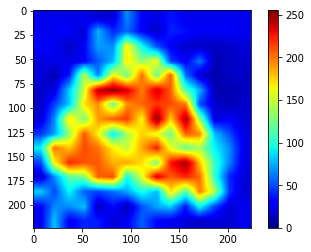

In [178]:
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) ,cmap="jet")
plt.colorbar()

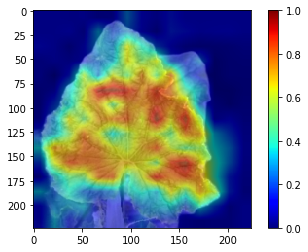

In [179]:
plt.imshow(cv2.cvtColor(cam_img / 255, cv2.COLOR_BGR2RGB) ,cmap="jet")
plt.colorbar()

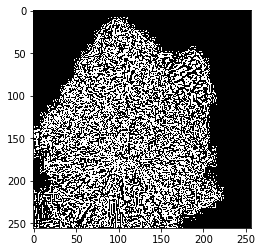

In [180]:
image = dataset.img_paths[3500]
row_img1 = cv2.imread(image, 0)
lap5 = cv2.Laplacian(row_img1, cv2.CV_32F,ksize=3)
ret2,th2 = cv2.threshold(np.uint8(lap5),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(cv2.cvtColor(th2, cv2.COLOR_BGR2RGB))

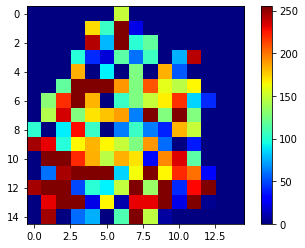

In [181]:
aaa = cv2.resize(th2, (15, 15))
a = np.reshape(aaa, (1, 1, 15, 15))
aaa = cv2.applyColorMap(np.uint8(aaa), cv2.COLORMAP_JET)
plt.imshow(cv2.cvtColor(aaa, cv2.COLOR_BGR2RGB) ,cmap="jet")
plt.colorbar()

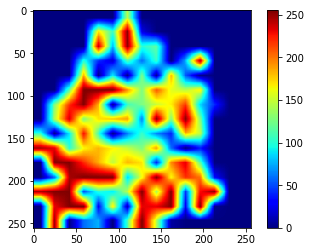

In [187]:
aaa = cv2.resize(th2, (15, 15))
aaa = cv2.resize(aaa, (256, 256))
aaa = cv2.applyColorMap(np.uint8(aaa), cv2.COLORMAP_JET)
plt.imshow(cv2.cvtColor(aaa, cv2.COLOR_BGR2RGB) ,cmap="jet")
plt.colorbar()

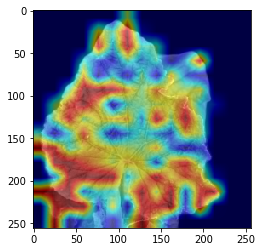

In [189]:
image1 = row_img1 - np.min(row_img1)
image1 = np.minimum(image1, 255)
cam_img = np.float32(aaa) + np.float32(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
cam_img = 255 * cam_img / np.max(cam_img)
plt.imshow(cv2.cvtColor(cam_img / 255, cv2.COLOR_BGR2RGB))

In [190]:
x = Variable((a/255).astype(np.float32))
b = (model.predictor.att + x) * model.predictor.att
b = b/np.max(b.data)
b

variable([[[[0.11192788, 0.11192788, 0.10579844, 0.11227365, 0.08218729,
             0.08646318, 0.26161784, 0.12406139, 0.10004092, 0.14583701,
             0.11009081, 0.1120031 , 0.11192788, 0.11192788, 0.11192788],
            [0.11010315, 0.11339374, 0.12476873, 0.0846893 , 0.302079  ,
             0.16379035, 0.22738981, 0.12125957, 0.06860917, 0.15923497,
             0.13785209, 0.11579725, 0.12180902, 0.12475756, 0.11172995],
            [0.13288707, 0.11370505, 0.07338528, 0.11877636, 0.2834201 ,
             0.26275244, 0.6397405 , 0.3901204 , 0.20471783, 0.11604472,
             0.07695474, 0.06417532, 0.06953876, 0.07606828, 0.08966979],
            [0.09015583, 0.10966218, 0.09740055, 0.12154408, 0.21314849,
             0.30635715, 0.6512038 , 0.5140743 , 0.6206929 , 0.18301232,
             0.11397997, 0.24341051, 0.05158871, 0.0723273 , 0.07646979],
            [0.09416872, 0.04910356, 0.14958294, 0.56822336, 0.24692915,
             0.62296134, 0.47652343, 0.77364844

In [191]:
heatmap = cv2.resize(b.data[0][0], (224, 224))
heatmap = cv2.applyColorMap(np.uint8(heatmap*255), cv2.COLORMAP_JET)
image = img[0, :].transpose(1, 2, 0) * 255
image -= np.min(image)
image = np.minimum(image, 255)
cam_img = np.float32(heatmap) + np.float32(image)
cam_img = 255 * cam_img / np.max(cam_img)

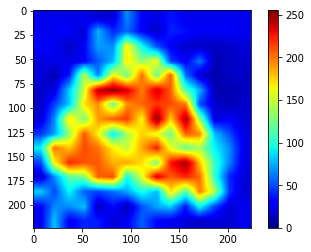

In [192]:
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) ,cmap="jet")
plt.colorbar()

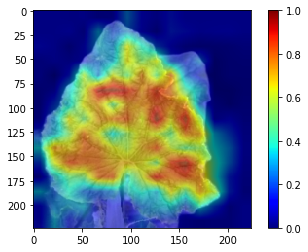

In [176]:
plt.imshow(cv2.cvtColor(cam_img / 255, cv2.COLOR_BGR2RGB) ,cmap="jet")
plt.colorbar()